In [1]:

import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [2]:
class VOCDataset(Dataset):
    def __init__(self, root_dir, year='2012', image_set='train', transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_dir = os.path.join(root_dir, 'VOCdevkit', 'VOC' + year, 'JPEGImages')

        # Load image ids from the corresponding split text file
        split_file = os.path.join(root_dir, 'VOCdevkit', 'VOC' + year, 'ImageSets', 'Main', image_set + '.txt')
        with open(split_file, 'r') as file:
            self.image_ids = file.read().split()

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_path = os.path.join(self.image_dir, img_id + '.jpg')
        image = Image.open(img_path).convert('RGB')
        gray_image = Image.open(img_path).convert('L')  # Convert to grayscale

        if self.transform:
            image = self.transform(image)
            gray_image = self.transform(gray_image)

        return gray_image, image


In [3]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])


dataset_root = '' 
voc_dataset = VOCDataset(root_dir=dataset_root, transform=transform)
dataloader = DataLoader(voc_dataset, batch_size=16, shuffle=True)


In [4]:

for i, (images, labels) in enumerate(dataloader):
    print(f"Batch {i+1}")
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    if i == 5:  # Stop after 6 batches
        break


Batch 1
Images shape: torch.Size([16, 1, 256, 256])
Labels shape: torch.Size([16, 3, 256, 256])
Batch 2
Images shape: torch.Size([16, 1, 256, 256])
Labels shape: torch.Size([16, 3, 256, 256])
Batch 3
Images shape: torch.Size([16, 1, 256, 256])
Labels shape: torch.Size([16, 3, 256, 256])
Batch 4
Images shape: torch.Size([16, 1, 256, 256])
Labels shape: torch.Size([16, 3, 256, 256])
Batch 5
Images shape: torch.Size([16, 1, 256, 256])
Labels shape: torch.Size([16, 3, 256, 256])
Batch 6
Images shape: torch.Size([16, 1, 256, 256])
Labels shape: torch.Size([16, 3, 256, 256])


In [5]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        
        self.encoder1 = self.conv_block(1, 32) 
        self.encoder2 = self.conv_block(32, 64)
        self.encoder3 = self.conv_block(64, 128)
        self.encoder4 = self.conv_block(128, 256)
        self.down = nn.MaxPool2d(2)

        
        # Bottleneck
        self.bottleneck = self.conv_block(256, 512)

        # Decoder (Upsampling and concatenation path)
        self.upconv4 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv4 = self.conv_block(256 + 256, 256)
        self.upconv3 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv3 = self.conv_block(128 + 128, 128)
        self.upconv2 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv2 = self.conv_block(64 + 64, 64)
        self.upconv1 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.conv1 = self.conv_block(32 + 32, 32)

        # Final layer
        self.final_conv = nn.Conv2d(32, 3, kernel_size=1)

    def forward(self, x):
        enc1 = self.encoder1(x)
        down1 = self.down(enc1)
        
        enc2 = self.encoder2(down1)
        down2 = self.down(enc2)
        
        enc3 = self.encoder3(down2)
        down3 = self.down(enc3)
        
        enc4 = self.encoder4(down3)
        down4 = self.down(enc4)
        
        bottleneck = self.bottleneck(down4)
        
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat([dec4, enc4], dim=1)
        dec4 = self.conv4(dec4)
        
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat([dec3, enc3], dim=1)
        dec3 = self.conv3(dec3)
        
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat([dec2, enc2], dim=1)
        dec2 = self.conv2(dec2)
        
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat([dec1, enc1], dim=1)
        dec1 = self.conv1(dec1)
        output = self.final_conv(dec1)
        return output

    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels))
        return block

# Model instantiation and testing dimension flow
model = UNet()
dummy_input = torch.randn(1, 1, 256, 256)  # Example input tensor
output = model(dummy_input)



In [6]:
model = UNet().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 30
model.train()
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for gray_images, color_images in dataloader:
        gray_images = gray_images.to(device)  # gray_images already have the correct shape [batch, 1, H, W]
        color_images = color_images.to(device)
        
        optimizer.zero_grad()
        outputs = model(gray_images)  # Make sure the input here is [batch, 1, H, W]
        loss = criterion(outputs, color_images)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(dataloader):.4f}')



Epoch [1/30], Loss: 0.0581
Epoch [2/30], Loss: 0.0074
Epoch [3/30], Loss: 0.0073
Epoch [4/30], Loss: 0.0072
Epoch [5/30], Loss: 0.0071
Epoch [6/30], Loss: 0.0071
Epoch [7/30], Loss: 0.0071
Epoch [8/30], Loss: 0.0071
Epoch [9/30], Loss: 0.0069
Epoch [10/30], Loss: 0.0071
Epoch [11/30], Loss: 0.0070
Epoch [12/30], Loss: 0.0070
Epoch [13/30], Loss: 0.0068
Epoch [14/30], Loss: 0.0068
Epoch [15/30], Loss: 0.0068
Epoch [16/30], Loss: 0.0069
Epoch [17/30], Loss: 0.0069
Epoch [18/30], Loss: 0.0069
Epoch [19/30], Loss: 0.0068
Epoch [20/30], Loss: 0.0068
Epoch [21/30], Loss: 0.0068
Epoch [22/30], Loss: 0.0066
Epoch [23/30], Loss: 0.0065
Epoch [24/30], Loss: 0.0065
Epoch [25/30], Loss: 0.0066
Epoch [26/30], Loss: 0.0066
Epoch [27/30], Loss: 0.0065
Epoch [28/30], Loss: 0.0063
Epoch [29/30], Loss: 0.0063
Epoch [30/30], Loss: 0.0062


In [8]:
torch.save(model, 'model1.pth')
torch.save(model.state_dict(), 'model_state_dict1.pth')

In [21]:
def visualize_results(data_loader, model, device, num_images=16):
    model.eval()
    images, color_images = next(iter(data_loader))
    images, color_images = images.to(device), color_images.to(device)
    
    # Ensure the images are properly shaped
    print("Image shape before model:", images.shape)  # Debugging line

    with torch.no_grad():
        outputs = model(images)
    
    images = images.cpu().squeeze()  # Adjust based on actual dimension requirements
    color_images = color_images.cpu()
    outputs = outputs.cpu()
    
    fig, axs = plt.subplots(num_images, 3, figsize=(10, num_images * 2.5))
    for i in range(num_images):
        axs[i, 0].imshow(images[i].squeeze(), cmap='gray')  # Ensure correct use of squeeze
        axs[i, 1].imshow(color_images[i].permute(1, 2, 0))
        axs[i, 2].imshow(outputs[i].permute(1, 2, 0))
        axs[i, 0].set_title('Grayscale Input')
        axs[i, 1].set_title('Original Color Image')
        axs[i, 2].set_title('Reconstructed Color Output')
        axs[i, 0].axis('off')
        axs[i, 1].axis('off')
        axs[i, 2].axis('off')
    plt.show()


Image shape before model: torch.Size([16, 1, 256, 256])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


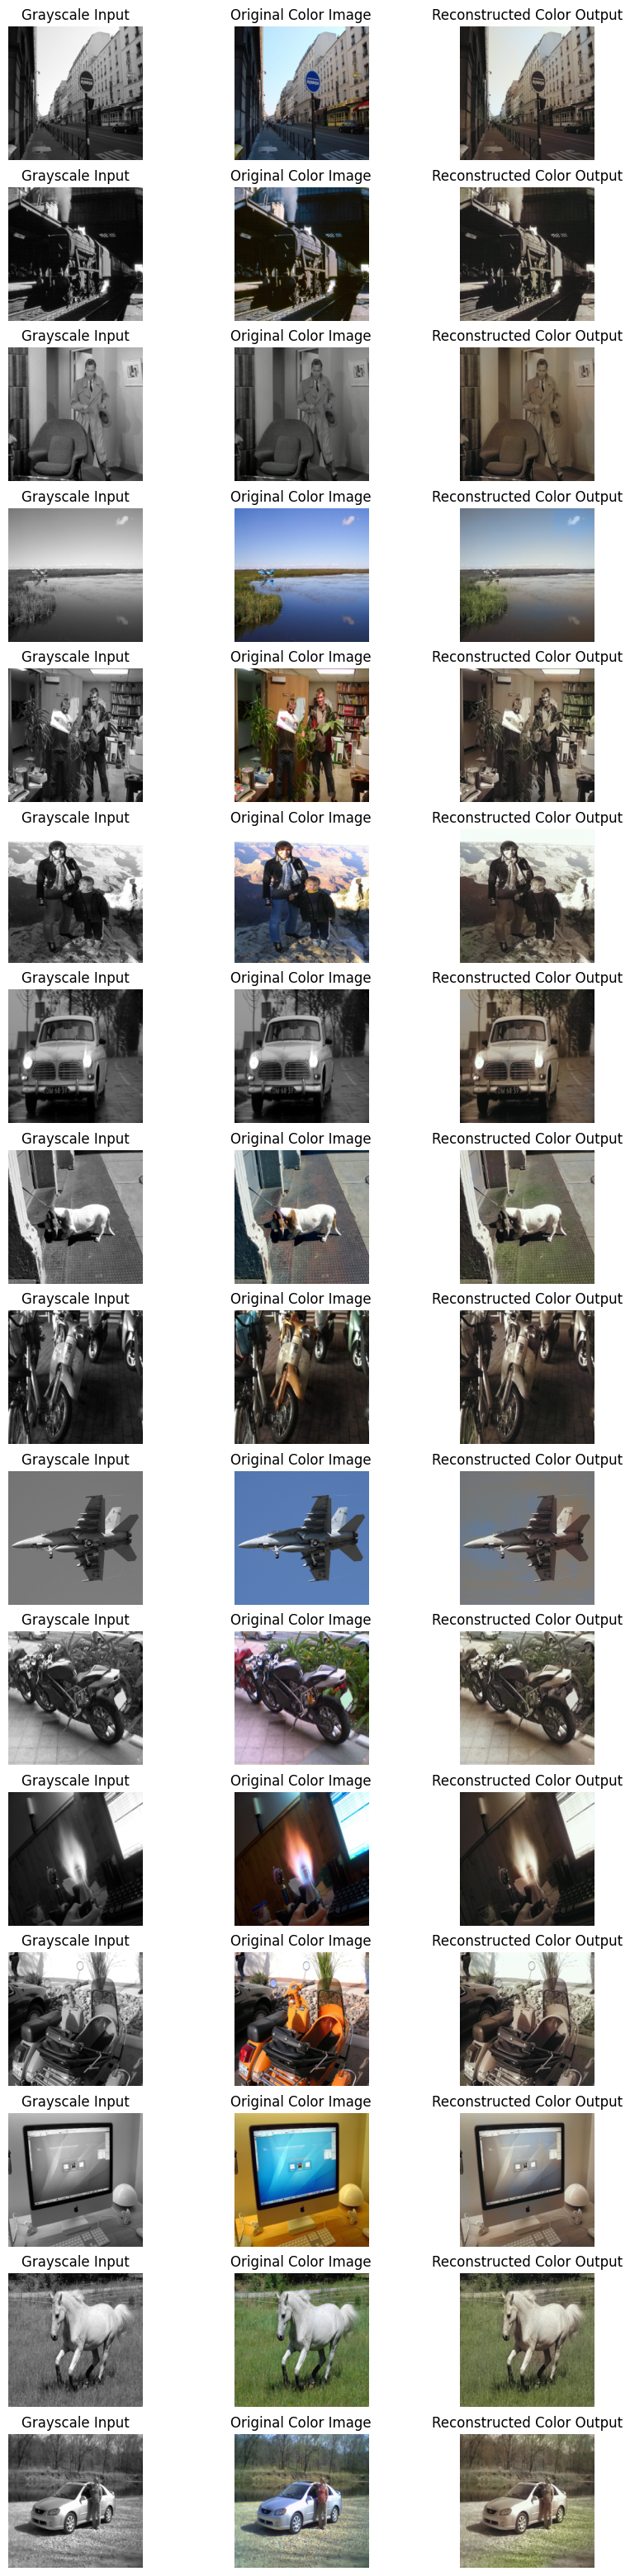

In [22]:
visualize_results(dataloader, model, device)